In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow import keras


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes=10

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10
image_size = 32
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]
input_shape=(image_size, image_size, 3)

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)


In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        # Compute the dimensions dynamically in the graph
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]
        channels = tf.shape(images)[3]

        # Calculate the number of patches in each dimension
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        # Extract patches using tf.image.extract_patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )

        # Reshape the patches to the desired format
        patch_dim = self.patch_size * self.patch_size * channels
        patches = tf.reshape(patches, [batch_size, num_patches_h * num_patches_w, patch_dim])

        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


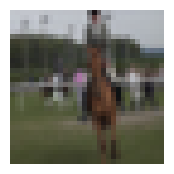

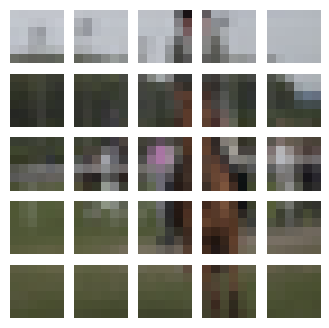

In [7]:
plt.figure(figsize=(2, 2))
sample_image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(sample_image)
plt.axis("off")
plt.show()

resized_image = tf.image.resize(sample_image, [image_size, image_size])
resized_image_with_batch = tf.expand_dims(resized_image, axis=0)
patches = Patches(patch_size)(resized_image_with_batch)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, [patch_size, patch_size, 3])
    plt.imshow(patch_img.numpy())
    plt.axis("off")
plt.show()


In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions = tf.expand_dims(positions, axis=0)

        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": projection_dim})
        return config


In [9]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


Epoch 1/10
352/352 [==============================] - 57s 57ms/step - loss: 1.8999 - accuracy: 0.3306 - top-5-accuracy: 0.8275 - val_loss: 1.4841 - val_accuracy: 0.4562 - val_top-5-accuracy: 0.9180
Epoch 2/10
352/352 [==============================] - 18s 52ms/step - loss: 1.5851 - accuracy: 0.4298 - top-5-accuracy: 0.8964 - val_loss: 1.3267 - val_accuracy: 0.5176 - val_top-5-accuracy: 0.9388
Epoch 3/10
352/352 [==============================] - 21s 58ms/step - loss: 1.4800 - accuracy: 0.4706 - top-5-accuracy: 0.9135 - val_loss: 1.2666 - val_accuracy: 0.5474 - val_top-5-accuracy: 0.9386
Epoch 4/10
352/352 [==============================] - 18s 51ms/step - loss: 1.4117 - accuracy: 0.4976 - top-5-accuracy: 0.9237 - val_loss: 1.1970 - val_accuracy: 0.5764 - val_top-5-accuracy: 0.9508
Epoch 5/10
352/352 [==============================] - 19s 53ms/step - loss: 1.3541 - accuracy: 0.5197 - top-5-accuracy: 0.9314 - val_loss: 1.1529 - val_accuracy: 0.5906 - val_top-5-accuracy: 0.9524
Epoch 6/10

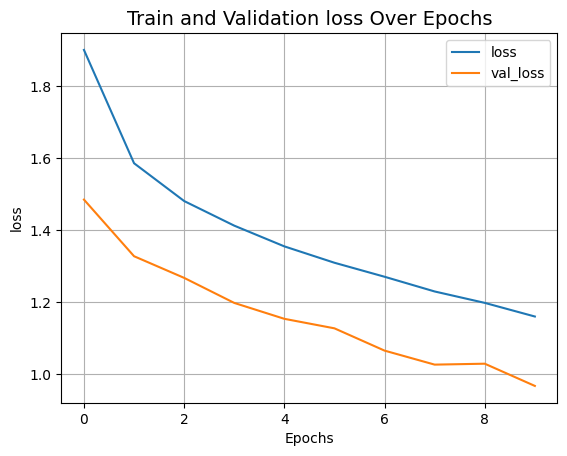

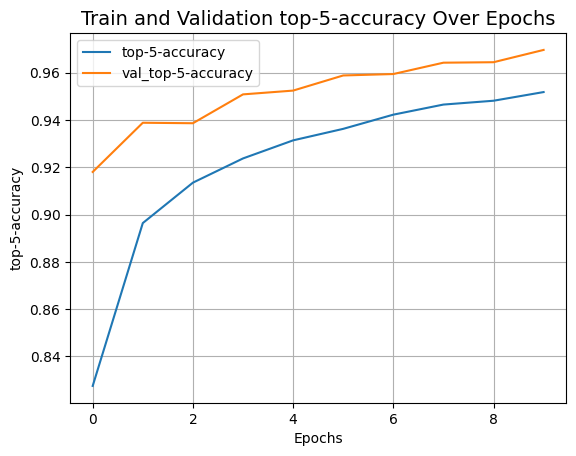

In [13]:

def run_experiment(model):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )



    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")


1/1 [==============================] - 3s 3s/step


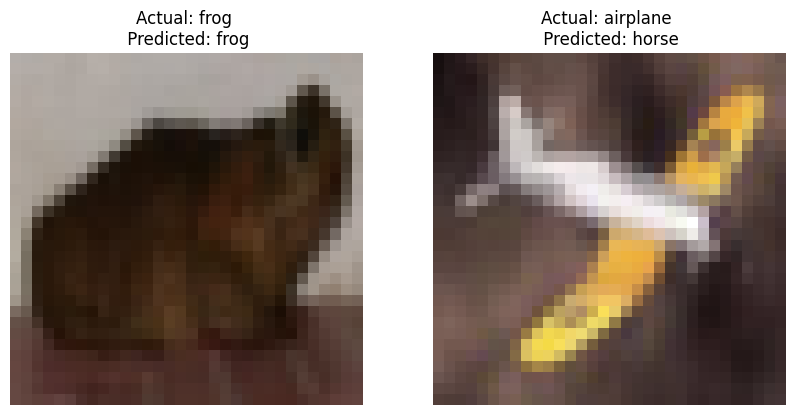

In [14]:
def decode_predictions(preds, classes):
    return np.argmax(preds, axis=1)

num_samples = 2
indices = np.random.choice(range(len(x_test)), num_samples, replace=False)
sample_images = x_test[indices]
sample_labels = y_test[indices]

sample_images_resized = tf.image.resize(sample_images, [image_size, image_size])

predictions = vit_classifier.predict(sample_images_resized)
predicted_classes = decode_predictions(predictions, num_classes)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 5))
for i, index in enumerate(indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Actual: {class_names[np.argmax(sample_labels[i])]} \n Predicted: {class_names[predicted_classes[i]]}")
    plt.axis("off")
plt.show()
